## Let's vectorize our data to explore it

### Different ways to split data

#### Random Split

First, let's split our data randomly in train and test

In [31]:
from data_processing import format_raw_df

df = pd.DataFrame.from_csv('data/writers.csv')
df = format_raw_df(df.copy())

/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [32]:
from data_processing import get_random_train_test_split, get_vectorized_inputs_and_label

train_df_rand, test_df_rand = get_random_train_test_split(df[df["is_question"]], test_size=0.2, random_state=40)

In [33]:
len(train_df_rand), len(test_df_rand)

(6376, 1595)

#### Author Split

Some authors may be more successful on average, and that may due to factors other than the quality of their formulation such as their popularity. To remove this potential source of bias, we could split by author

In [34]:
from data_processing import get_split_by_author

train_author, test_author = get_split_by_author(df[df["is_question"]])

print("%s questions in training, %s in test." % (len(train_author),len(test_author)))
train_owners = set(train_author['OwnerUserId'].values)
test_owners = set(test_author['OwnerUserId'].values)
print("%s different owners in the training set" % len(train_owners))
print("%s different owners in the testing set" % len(test_owners))
print("%s overlapping owners" % len(train_owners.intersection(test_owners)))

5676 questions in training, 2295 in test.
2723 different owners in the training set
1167 different owners in the testing set
0 overlapping owners


### Now let's vectorize our text

#### TF-IDF on ngrams

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

questions = train_author[train_author["is_question"]]
raw_text = questions["body_text"]
sent_labels = questions["AcceptedAnswerId"].notna()

sent_labels.value_counts()

True     2907
False    2769
Name: AcceptedAnswerId, dtype: int64

In [36]:
# Create an instance of a tfidf vectorizer, 
# We could use CountVectorizer for a non normalized version
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)

# Fit our vectorizer to questions in our dataset
# Returns an array of vectorized text
bag_of_words = vectorizer.fit_transform(raw_text)

bag_of_words.shape

(5676, 27381)

In [37]:
import umap

umap_embedder = umap.UMAP()
umap_bow = umap_embedder.fit_transform(bag_of_words)

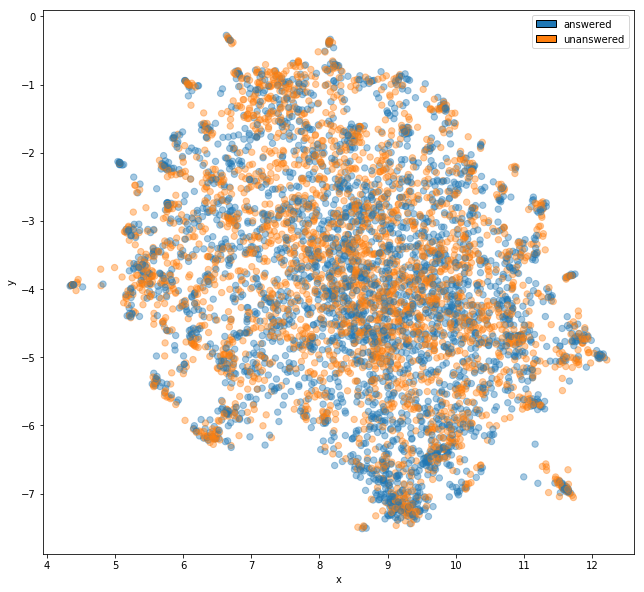

In [38]:
def plot_embeddings(embeddings):
    fig = plt.figure(figsize=(16, 10))
    color_map = {
        True: '#1f77b4',
        False:'#ff7f0e'
    }
    plt.scatter(embeddings[:, 0], embeddings[:, 1], 
                c=[color_map[x] for x in sent_labels], 
              s=40, alpha=0.4)

    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
               ['#1f77b4', '#ff7f0e']]
    labels = ["answered", "unanswered"]
    plt.legend(handles, labels)

    plt.gca().set_aspect('equal', 'box')
    plt.gca().set_xlabel("x")
    plt.gca().set_ylabel("y")

plot_embeddings(umap_bow)

#### Pre-trained word embeddings

In [ ]:
import spacy
import umap
import numpy as np 
# Load a large model, and disable pipeline unnecessary parts for our task
# This speeds up the vectorization process significantly
# See https://spacy.io/models/en#en_core_web_lg for details about the model
nlp = spacy.load('en_core_web_lg', disable=["parser", "tagger", "ner", "textcat"])

In [ ]:
# Get the vector for each of our questions
# By default, the vector returned is the average of all vectors in the sentence
# See https://spacy.io/usage/vectors-similarity for more
spacy_emb = train_author[train_author["is_question"]]["body_text"].apply(lambda x: nlp(x).vector)
embeddings = np.vstack(spacy_emb)

In [ ]:
# embeddings = list(spacy_emb)

umap_embedder = umap.UMAP()
umap_emb = umap_embedder.fit_transform(embeddings)

In [ ]:
plot_embeddings(umap_emb)

Initially, our different classes do not seem that well separated at all, let's go through the data and see if we can find any patterns to create a few features that could be useful.

In [ ]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, Category10

output_notebook()

def get_interactive_umap_embeddings_plot(umap_vectors, labels, text, legends, tooltip_label=None):
    if not tooltip_label:
        print("Using standard label")
        tooltip_label = labels
    w2v_df = pd.DataFrame(umap_vectors, columns=('x', 'y'))
    print(len(w2v_df))
    w2v_df['label'] = [str(x) for x in labels]
    w2v_df['tooltip_label'] = [str(x) for x in tooltip_label]
    w2v_df['text'] = list(text)
    w2v_df['legends'] = ["Answered" if el else "Unanswered" for el in list(legends)]
    datasource = ColumnDataSource(w2v_df)

    color_mapping = CategoricalColorMapper(factors=['True','False'], palette=['#1f77b4', '#ff7f0e'])

    TOOLTIPS = [
        ("text", "@text"),
        ('got_answer', '@tooltip_label')
    ]
    hover = HoverTool(tooltips=TOOLTIPS)
    hover.attachment ='right'

    plot_figure = figure(
        title='UMAP projection of questions',
        plot_width=900,
        plot_height=600,
        tools=('pan, wheel_zoom, reset', 'box_zoom', 'undo')
    )
    plot_figure.add_tools(hover)
    
    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='label', transform=color_mapping),
        legend='legends',
        line_alpha=0,
        fill_alpha=0.4,
        size=5
    )
    return plot_figure

# plot_figure = get_interactive_umap_embeddings_plot(umap_emb, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

In [ ]:
df["body_text_question"].fillna("", inplace=True)

def show_question_features_containing(text):
    return df[df["body_text_question"].str.contains(text)][["body_text", "CommentCount", "text_len", 
                                                             "body_text_question", "text_len_question", 
                                                       "Score_question", "AcceptedAnswerId_question"]]

# Good example of two similar questions
show_question_features_containing("I'm an amateur writer")


## Potential features

Looking at the examples above, we can already think of a few features that could make our model better. To start with, we could generate features for:
- question length
- presence of question mark
- vocabulary associated with a clear question (action verbs, etc...)

In [ ]:
df["action_verb"] = (df["body_text"].str.contains("can", regex=False) | df["body_text"].str.contains("What", regex=False) | df["body_text"].str.contains("should", regex=False)).astype(int)
df["question_mark"] = df["body_text"].str.contains("?", regex=False)


In [ ]:
df["action_verb"].value_counts()

In [ ]:
df["question_mark"].value_counts()

In [ ]:
df["norm_text_len"]= get_normalized_series(df, "text_len")

In [ ]:
# Appending our generated features to word features

train_author, test_author = get_split_by_author(df[df["is_question"]])
vectorized_features = np.append(np.array(embeddings), train_author[train_author["is_question"]][["action_verb","question_mark", 
                                                                            "norm_text_len"]], 1)

vectorized_features.shape

In [ ]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

In [ ]:
plot_embeddings(umap_features)

In [ ]:
# plot_figure = get_interactive_umap_embeddings_plot(umap_features, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

In [ ]:
show_question_features_containing("capitalize")
show_question_features_containing("abbreviate")
show_question_features_containing("Specifically, how to describe")

# The title actually describes a lot of information
df[df["body_text"].str.contains("Specifically, how to describe", regex=False)][["body_text", "Title"]]


In [ ]:
df["language_question"] = (df["body_text"].str.contains("punctuate", regex=False) | df["body_text"].str.contains("capitalize", regex=False) | df["body_text"].str.contains("abbreviate", regex=False)).astype(int)


In [ ]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=' ', na_rep='')

In [ ]:
df["action_verb_full"] = (df["full_text"].str.contains("can", regex=False) | df["full_text"].str.contains("What", regex=False) | df["full_text"].str.contains("should", regex=False)).astype(int)
df["question_mark_full"] = df["full_text"].str.contains("?", regex=False)


In [ ]:
from data_processing import add_features_to_df
df = add_features_to_df(df.loc[df["is_question"]].copy())

In [ ]:
from data_processing import get_vectorized_inputs_and_label

In [ ]:
train_author, test_author = get_split_by_author(df[df["is_question"]])

spacy_emb_full = train_author[train_author["is_question"]]["full_text"].apply(lambda x: nlp(x).vector)

In [ ]:
vectorized_features, _ = get_vectorized_inputs_and_label(df)

In [ ]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

In [ ]:
plot_embeddings(umap_features)

In [ ]:
# plot_figure = get_interactive_umap_embeddings_plot(umap_features, sent_labels, raw_text, legends=sent_labels)
# show(plot_figure)

## Let's cluster our data

First we will try a manual approach

Then, we will sweep through cluster sizes and examine silhouette scores

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# Choose number of clusters and colormap
n_clusters=3
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering

# TODO show silhouette scores for different embedders
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = [2, 3, 4, 5, 6]

to_clus = vectorized_features

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-.3, .4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(to_clus) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(to_clus)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centerss = clusterer.cluster_centers_
    print(centerss.shape)
    centers = umap_embedder.transform(centerss)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
#         a = umap_embedder.transform([c])[0]
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')